In [4]:
# Key Questions:
# What are the most important attributes for an Ideal Student Life ?
# What factors leads to Stress, More Participation, More Interaction, More Satisfaction ?
# Does more stress leads to less satisfaction?
# What factors lead to increased stress among the students?

import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from keras import layers
from keras.models import save_model
import seaborn as sns

In [5]:
all_columns = [
    "Career",  # str
    "Citizenship",  # str
    "Nationality",  # str
    "Year since Matriculation",  # int
    "Year of Study",  # int
    "Primary Programme",  # str
    "Gender",  # str
    "Department",  # str
    "Housing Type",  # str
    "Q1-How many events have you Volunteered in ?",  # int
    "Q2-How many events have you Participated in ?",  # int
    "Q3-How many activities are you Interested in ?",  # int
    "Q4-How many activities are you Passionate about ?",  # int
    "Q5-What are your levels of stress ?",  # int
    "Q6-How Satisfied You are with your Student Life ?",  # int
    "Q7-How much effort do you make to interact with others ?",  # float
    "Q8-About How events are you aware about ?",  # float
    "Q9-What is an ideal student life ?",  # long str
    "response_id",  # int
]

numerical_columns = [
    "Q1-How many events have you Volunteered in ?",  # int
    "Q2-How many events have you Participated in ?",  # int
    "Q3-How many activities are you Interested in ?",  # int
    "Q4-How many activities are you Passionate about ?",  # int
    "Q7-How much effort do you make to interact with others ?",  # float
    "Q8-About How events are you aware about ?",  # float
]

categorical_columns = [
    "Career",  # str
    "Citizenship",  # str
    "Nationality",  # str
    "Primary Programme",  # str
    "Gender",  # str
    "Department",  # str
    # "Housing Type",  # str
]

numerical_categorical_columns = [
    "Year since Matriculation",  # int
    "Year of Study",  # int
]

unused_columns = [
    "response_id",  # int
    "Q9-What is an ideal student life ?",  # long str
]

missing_columns = [
    "Q7-How much effort do you make to interact with others ?",  # float
    "Q8-About How events are you aware about ?",  # float
]

In [6]:
# TARGET_COLUMN = "Q5-What are your levels of stress ?"
# TARGET_MAX = 9
TARGET_COLUMN = "Q6-How Satisfied You are with your Student Life ?"  # int
TARGET_MAX = 4

In [9]:

df = pd.read_csv("/kaggle/input/ideal-student-life-survey/survey_responses.csv")

df["target"] = np.where(df[TARGET_COLUMN] < math.floor(TARGET_MAX / 2), 0, 1)

df = df.drop(unused_columns, axis=1)

for col in missing_columns:
    df[col] = df[col].fillna(0)


train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])


def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop("target")
    df = {key: value[:, tf.newaxis] for key, value in df.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds.prefetch(batch_size)

    return ds


BATCH_SIZE = 32

train_ds = df_to_dataset(train, batch_size=BATCH_SIZE)
val_ds = df_to_dataset(val, shuffle=False, batch_size=BATCH_SIZE)
test_ds = df_to_dataset(test, shuffle=False, batch_size=BATCH_SIZE)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  app.launch_new_instance()
2022-08-01 19:06:11.181270: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
def get_numerical_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer


def category_encoding_layer_normalization(name, dataset, dtype, max_tokens=None):
    # Create a layer that turns strings into integer indices.
    if dtype == "string":
        index = layers.StringLookup(max_tokens=max_tokens)
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))

all_inputs = []
encoded_features = []

In [11]:
# Numerical features
for header in numerical_columns:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_numerical_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)

    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)


# Numerical Categorical features
for header in numerical_categorical_columns:
    categorical_column = layers.Input(shape=(1,), name=header, dtype="int64")
    test_layer = category_encoding_layer_normalization(header, train_ds, "int64")
    encoded_categorical_column = test_layer(categorical_column)

    all_inputs.append(categorical_column)
    encoded_features.append(encoded_categorical_column)


# Categorical features
for header in categorical_columns:
    categorical_column = layers.Input(shape=(1,), name=header, dtype="string")
    test_layer = category_encoding_layer_normalization(header, train_ds, "string")
    encoded_categorical_column = test_layer(categorical_column)

    all_inputs.append(categorical_column)
    encoded_features.append(encoded_categorical_column)

2022-08-01 19:06:32.064976: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [12]:

all_features = layers.Concatenate()(encoded_features)

x = layers.Dense(256, activation="relu")(all_features)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1)(x)

model = tf.keras.Model(inputs=all_inputs, outputs=output)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

model.compile(
    optimizer="adam",
    loss=loss,
    metrics=["accuracy"],
)

In [13]:

EPOCHS = 10

hist = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS).history


Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['Housing Type', 'Q5-What are your levels of stress ?', 'Q6-How Satisfied You are with your Student Life ?'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


74/74 [==============================] - 2s 13ms/step - loss: 0.4729 - accuracy: 0.7984 - val_loss: 0.3753 - val_accuracy: 0.8682
Epoch 2/10
74/74 [==============================] - 0s 5ms/step - loss: 0.4334 - accuracy: 0.8254 - val_loss: 0.3752 - val_accuracy: 0.8682
Epoch 3/10
74/74 [==============================] - 0s 5ms/step - loss: 0.4212 - accuracy: 0.8280 - val_loss: 0.3989 - val_accuracy: 0.8108
Epoch 4/10
74/74 [==============================] - 0s 5ms/step - loss: 0.4196 - accuracy: 0.8292 - val_loss: 0.3881 - val_accuracy: 0.8311
Epoch 5/10
74/74 [==============================] - 0s 5ms/step - loss: 0.4029 - accuracy: 0.8314 - val_loss: 0.3878 - val_accuracy: 0.8243
Epoch 6/10
74/74 [==============================] - 0s 5ms/step - loss: 0.3958 - accuracy: 0.8326 - val_loss: 0.3898 - val_accuracy: 0.8243
Epoch 7/10
74/74 [==============================] - 0s 5ms/step - loss: 0.3914 - accuracy: 0.8381 - val_loss: 0.3929 - val_accuracy: 0.8142
Epoch 8/10
74/74 [============

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Year since Matriculation (Input [(None, 1)]          0                                            
__________________________________________________________________________________________________
Year of Study (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
Career (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Citizenship (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

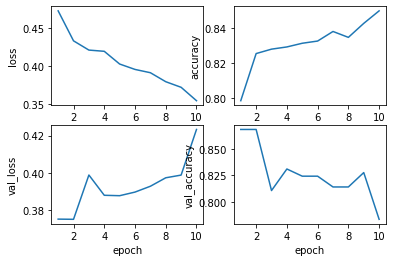

In [14]:
# creates an evenly filled array of the epochs
hist["epoch"] = np.linspace(1, EPOCHS, EPOCHS)

model.summary()

# plots the training and validation loss for each epoch
fig, ax = plt.subplots(2, 2)

sns.lineplot(x="epoch", y="loss", data=pd.DataFrame(hist), ax=ax[0, 0])
sns.lineplot(x="epoch", y="accuracy", data=pd.DataFrame(hist), ax=ax[0, 1])

sns.lineplot(
    x="epoch",
    y="val_loss",
    data=pd.DataFrame(hist),
    ax=ax[1, 0],
)
sns.lineplot(x="epoch", y="val_accuracy", data=pd.DataFrame(hist), ax=ax[1, 1])


plt.show()

In [15]:
loss, accuracy = model.evaluate(test_ds)
print("Test Accuracy: ", accuracy)

10/10 [==============================] - 0s 3ms/step - loss: 0.4700 - accuracy: 0.8142
Test Accuracy:  0.8141891956329346


In [16]:
# Input your own data here to predict your target variable.
# Use visualize.py to see the categorical types that best fit you
sample = {
    "Career": "UGRD",
    "Citizenship": "Country Citzen",
    "Nationality": "Singapore",
    "Year since Matriculation": 4,
    "Year of Study": 4,
    "Primary Programme": "Bachelor of Computing",
    "Gender": "M",
    "Department": "School of Science",
    "Housing Type": "Out of Campus",
    "Q1-How many events have you Volunteered in ?": 4,
    "Q2-How many events have you Participated in ?": 4,
    "Q3-How many activities are you Interested in ?": 6,
    "Q4-How many activities are you Passionate about ?": 5,
    # "Q5-What are your levels of stress ?": 1,
    # "Q6-How Satisfied You are with your Student Life ?": 1,
    "Q7-How much effort do you make to interact with others ?": 3.0,
    "Q8-About How events are you aware about ?": 3.0,
    # "Q9-What is an ideal student life ?": 1,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

prob = tf.nn.sigmoid(predictions[0])

print("probability you are satisfied with your student life: ", prob)

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['Housing Type'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


probability you are satisfied with your student life:  tf.Tensor([0.922493], shape=(1,), dtype=float32)
